In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.leeway import Leeway
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from matplotlib.lines import Line2D

In [2]:
d03 = xr.open_dataset('C:/Users/bente/Documents/BACKTRACK/backtracking/data/OO-2023.nc')       # all drifter data
d03 = d03.traj.gridtime('1H')
d03 = d03.isel(trajectory=0)             # drifter OO-2023-03

In [3]:
startlat = d03.lat.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values
startlon = d03.lon.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values

In [54]:
len(hits[0])

38

In [4]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})

object_type = 78  # 78 = Sewage floatables; downwind 1.8 percent wdf; no offset but stdev around 3 cm/s; right/left slope 0.16 percent

In [5]:
duration = timedelta(hours=288)                # 5 days
start_time = datetime(2023,2,2,3,12,8)
end_time = start_time + duration

In [8]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd0214feb_nodif100.nc"

In [56]:
orev = Leeway(loglevel=50)
orev.add_reader([reader_globcur, reader_wind])
orev.set_config('drift:advection_scheme', 'runge-kutta4')
#orev.set_config('drift:horizontal_diffusivity', 20)
orev.seed_elements(lon=startlon, lat=startlat, radius=10000, radius_type='uniform', number=28, time=end_time, object_type=object_type)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_bwd)

In [9]:
back = xr.open_dataset(outfile_bwd)

In [10]:
# diflon = np.max(back.isel(time=120).lon.values) - np.min(back.isel(time=120).lon.values)
# diflat = np.max(back.isel(time=120).lat.values) - np.min(back.isel(time=120).lat.values)

In [11]:
end_time

datetime.datetime(2023, 2, 14, 3, 12, 8)

In [12]:
# # Define domain of possible origin !!! WITH RANDOM UNIFORM SEEDING !!!
# lons = np.zeros((120,120))
# lats = np.zeros((120,120))
# for j in range(120):
#     lons[j] = np.random.uniform(np.min(back.isel(time=120).lon.values)-(0.5), np.max(back.isel(time=120).lon.values)+(0.5), 120) # Much coarser CCC
#     lats[j] = np.random.uniform(np.min(back.isel(time=120).lat.values)-(0.5), np.max(back.isel(time=120).lat.values)+(0.5), 120)

In [13]:
# np.min(back.lat.values)

In [14]:
# np.max(back.lat.values)

In [15]:
# Set the desired grid size
grid_size_lon = 0.480  # Change this to your desired grid size
grid_size_lat = 0.400

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(np.min(back.isel(time=288).lon.values)-(0.5), np.max(back.isel(time=288).lon.values)+(0.5), grid_size_lon)
lat_bins = np.arange(np.min(back.isel(time=288).lat.values)-(0.5), np.max(back.isel(time=288).lat.values)+(0.5), grid_size_lat)

In [16]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [17]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*200)-200))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*200)-200))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*200):((j+1)*200)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 200) # Much coarser CCC
        lats[i][(j*200):((j+1)*200)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 200)

# FWD

In [18]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd0214feb_nodif.nc"

In [14]:
ofwd = Leeway(loglevel=50)
ofwd.add_reader([reader_globcur, reader_wind])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')
#ofwd.set_config('drift:horizontal_diffusivity', 20)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)

In [19]:
fwd = xr.open_dataset(outfile)

In [20]:
len(fwd.trajectory)

8000

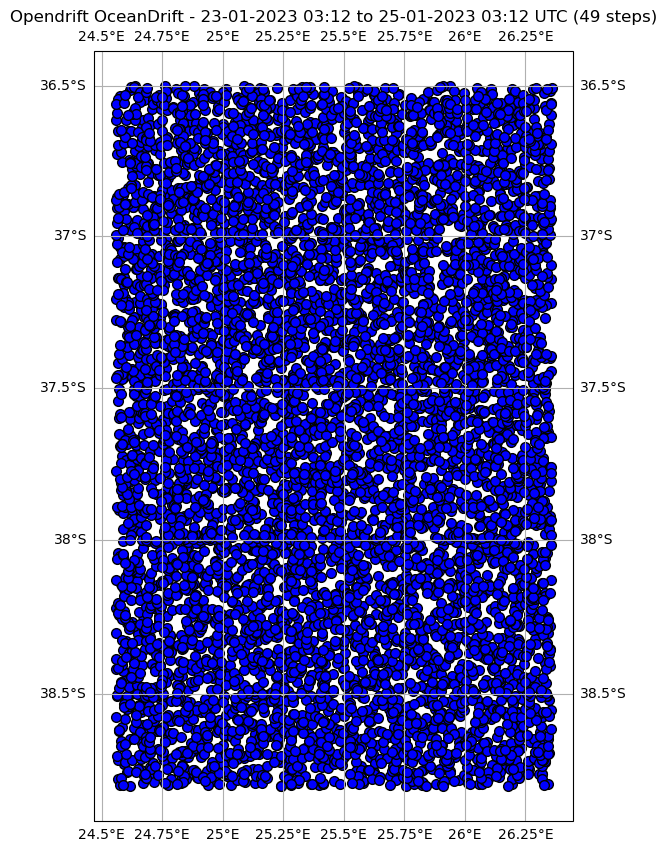

In [24]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

#fwd.traj.plot(linewidth=0.1)

for i in range(len(fwd.trajectory)):
    ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

#back.traj.plot(linewidth=0.1,color='red')

#d03.sel(time=slice('2023-01-25 03:12:08', '2023-01-30 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

In [21]:
ilat = d03.lat.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values
ilon = d03.lon.sel(time=slice(datetime(2023, 2, 14, 3, 12, 8), datetime(2023, 2, 14, 3, 12, 8))).values

In [22]:
## FORWARD ## 
lon0 = []
lat0 = []
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        ### calculating hits ###
        lon0.append(fwd.isel(trajectory=j).lon.values)
        lat0.append(fwd.isel(trajectory=j).lat.values)
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory
        
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(len(lonend0))
dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, ilon*on, ilat*on)
hits = np.where(dist2incident<10000)

hit_start_lons0= []
hit_start_lats0= []
for m in range(len(hits)):
        hit_start_lons0.append(lon0[hits[0][m]][0])
        hit_start_lats0.append(lat0[hits[0][m]][0])

In [ ]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())
#     ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 25-01-2023 03:12 to 27-01-2023 03:12 UTC (49 steps)')
plt.show()

KeyboardInterrupt: 

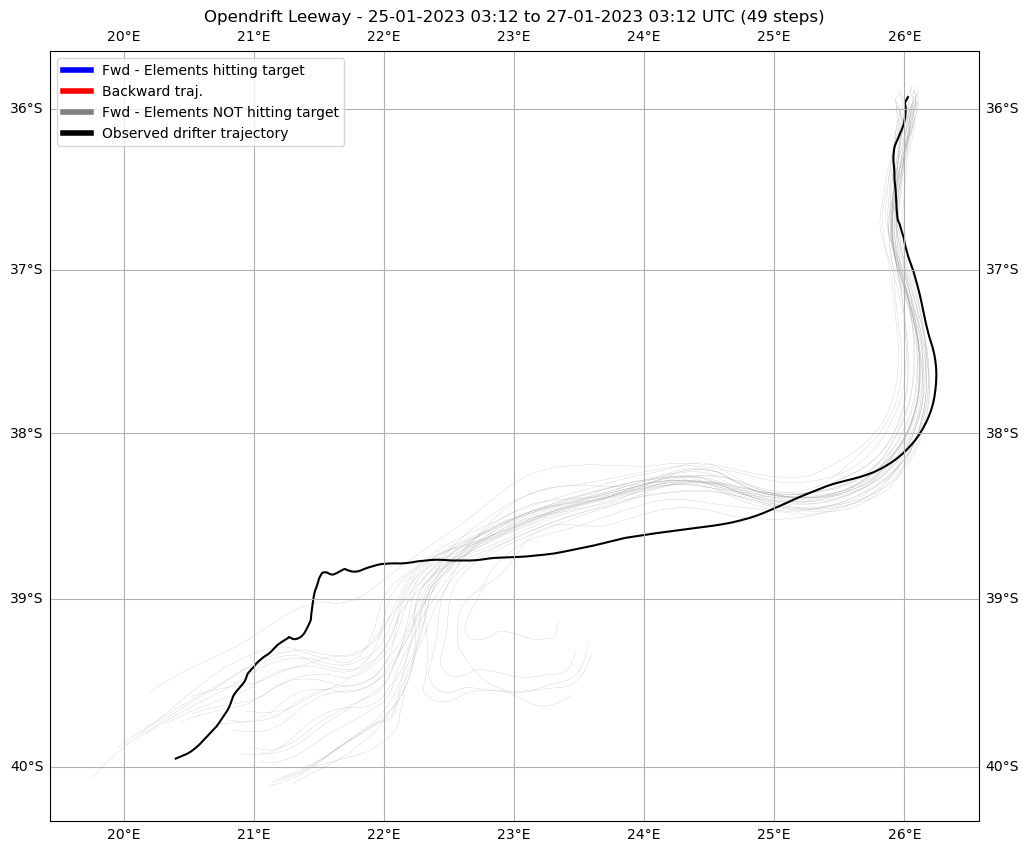

In [19]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(back.trajectory)):
    back.isel(trajectory=i).traj.plot(linewidth=0.1)
    
# for i in hits: 
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())
#     ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 25-01-2023 03:12 to 27-01-2023 03:12 UTC (49 steps)')
plt.show()

In [23]:
len(hits[0])

38

In [24]:
o_hit = opendrift.open(outfile, elements=hits[0])

16:27:57 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
16:27:57 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
16:27:57 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
16:27:57 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
16:27:57 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
16:27:57 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
16:27:57 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_fwd0214feb_nodif.nc
16:27:58 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
16:27:58 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
16:27:58 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
16:27:58 DEBUG   opendrift.export.io_net

16:27:59 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=False, lscale=None
16:27:59 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (18.95254287719727, 26.664070510864256, -40.629122924804676, -35.64203338623046)..
16:28:02 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (18.95254287719727, 26.664070510864256, -40.629122924804676, -35.64203338623046)..
16:28:03 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (18.95254287719727, 26.664070510864256, -40.629122924804676, -35.64203338623046)..


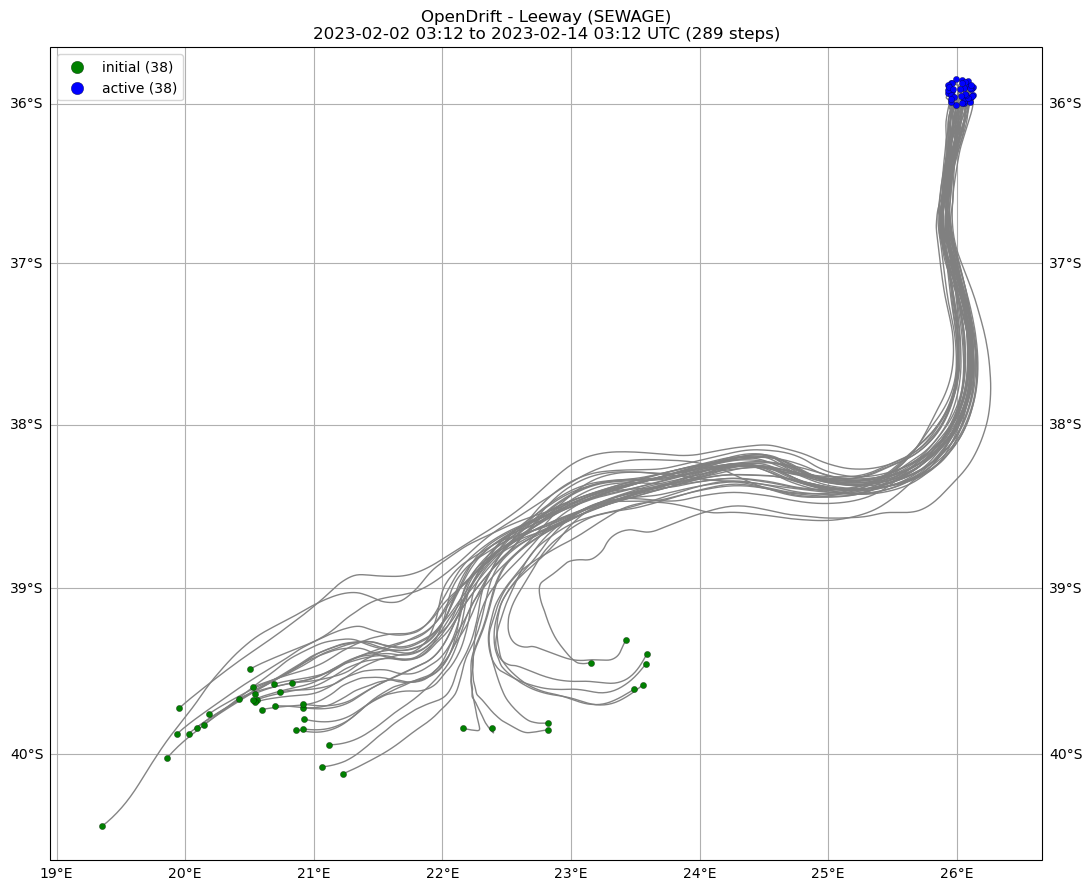

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 1 Axes>)

In [25]:
o_hit.plot()

13:45:05 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
13:45:05 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
13:45:05 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
13:45:05 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
13:45:05 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
13:45:05 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
13:45:05 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/oceandrift_48h/likelihood/lw_fwd0214feb_nodif.nc
13:45:05 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
13:45:05 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
13:45:06 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
13:45:06 WARNING opendrift.models.basemodel:3

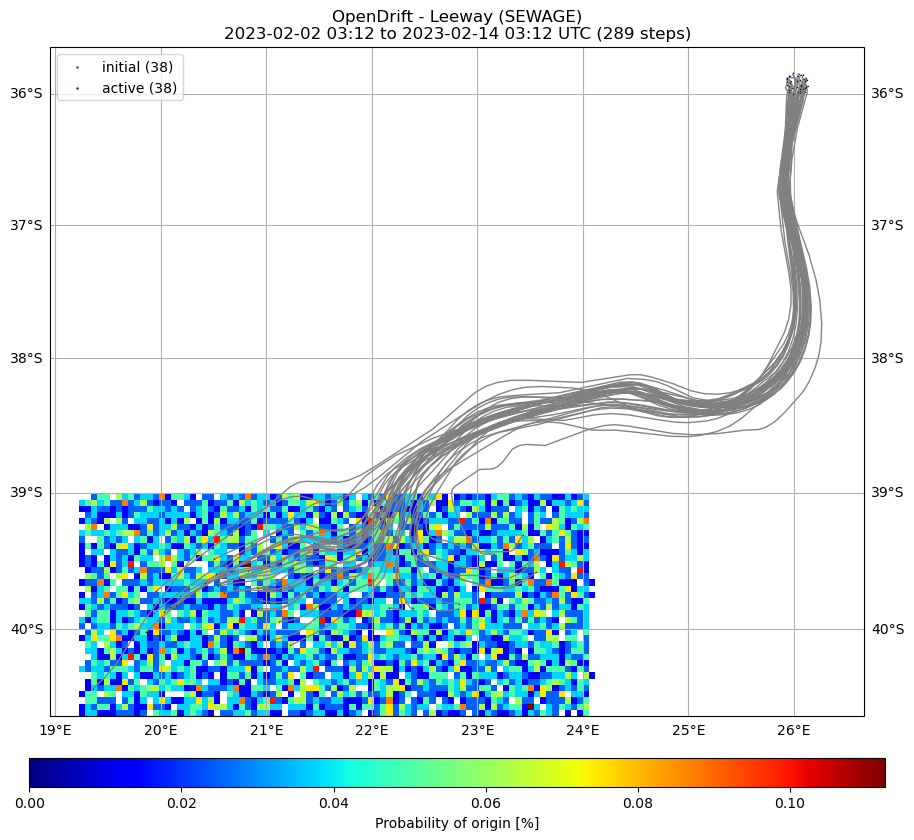

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 2 Axes>)

In [23]:
of = opendrift.open_xarray(outfile)
density_fwd = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_fwd = density_fwd.where(density_fwd>0)
density_fwd = density_fwd/density_fwd.sum()*100
vmax = density_fwd.max()
o_hit.plot(background=density_fwd, clabel='Probability of origin [%]', fast=True, markersize=.5, lalpha=.02, vmin=0)

In [24]:
# lonbin = np.arange(np.min(back.isel(time=48).lon.values)-(0.5), np.max(back.isel(time=48).lon.values)+(0.5), 0.025)
# latbin = np.arange(np.min(back.isel(time=48).lat.values)-(0.5), np.max(back.isel(time=48).lat.values)+(0.5), 0.025)

In [26]:
fwd = xr.open_dataset(outfile)

In [27]:
xfwd = fwd.isel(trajectory=hits[0])

#### Start lon and lat of FWD 'hits'

In [28]:
lon = []       # lon for 'hits'
lat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    lon.append(xfwd.isel(trajectory=i).lon.values[0])
    lat.append(xfwd.isel(trajectory=i).lat.values[0])

#### Start lon and lat of all FWD runs

In [29]:
lonall = []
latall = []

for i in range(len(fwd.trajectory)):
    lonall.append(fwd.isel(trajectory=i).lon.values[0])
    latall.append(fwd.isel(trajectory=i).lat.values[0])

In [29]:
# # Set the desired grid size
# grid_size_lon = 0.080  # Change this to your desired grid size
# grid_size_lat = 0.070

# # Calculate the number of grid cells in each dimension
# lon_bins = np.arange(np.min(lonall), np.max(lonall) + grid_size_lon, grid_size_lon)
# lat_bins = np.arange(np.min(latall), np.max(latall) + grid_size_lat, grid_size_lat)

In [30]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(lon, lat, lon_bins, lat_bins)

In [31]:
len(lon_bins)

11

16:28:28 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
16:28:28 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


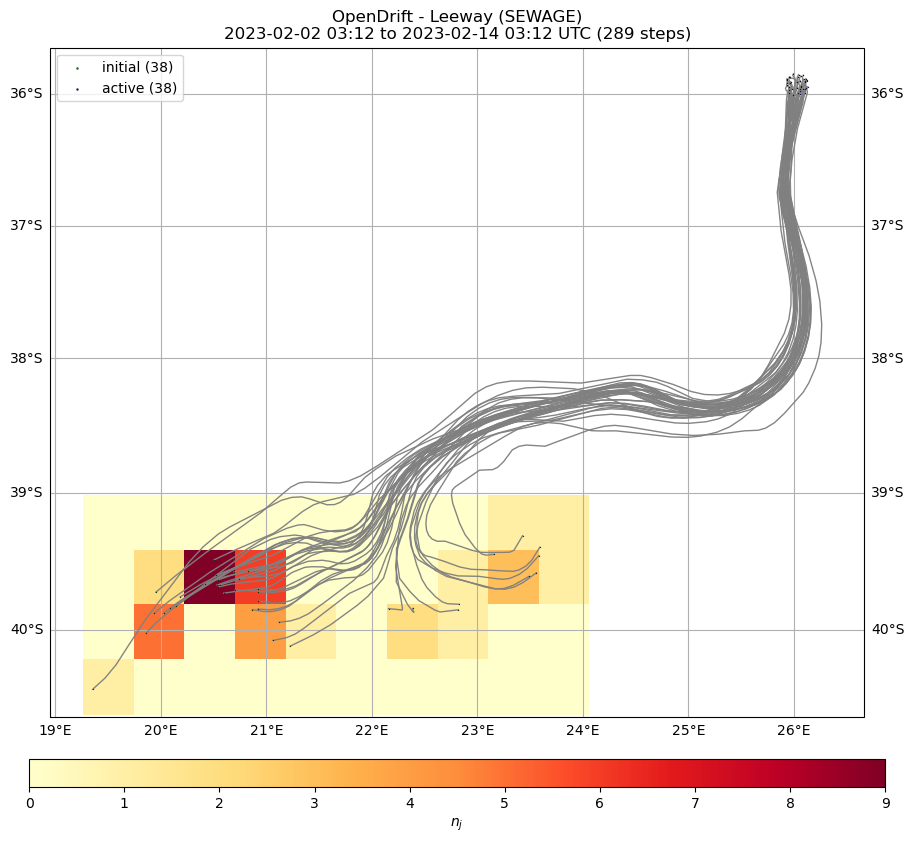

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 2 Axes>)

In [32]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

In [33]:
# Call the function to count points in grid cells
grid_counts_all = count_points_in_grid(lonall, latall, lon_bins, lat_bins)

13:46:13 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
13:46:13 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


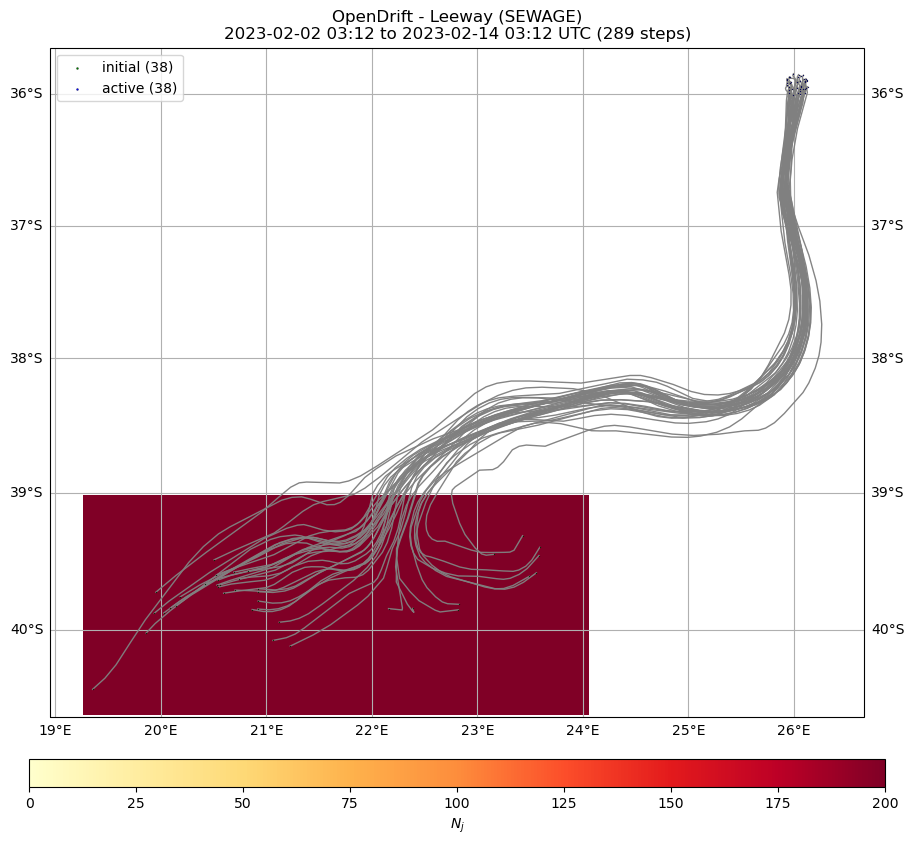

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 2 Axes>)

In [34]:
o_hit.plot(background=grid_counts_all, clabel='$N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

13:46:15 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
13:46:15 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


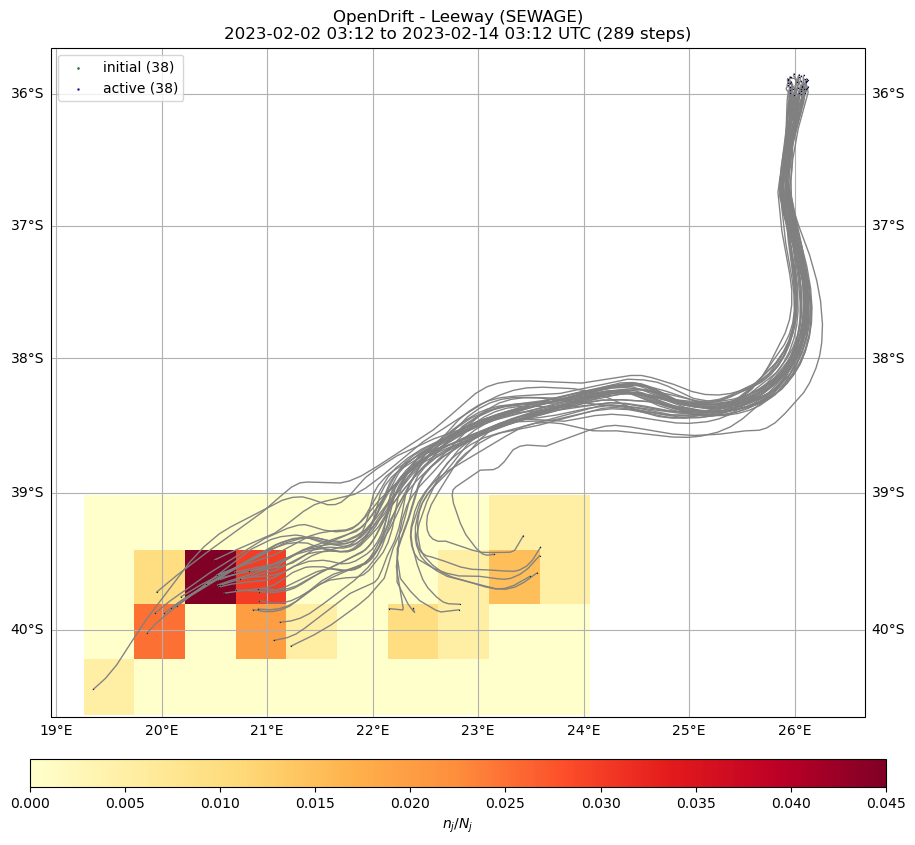

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 2 Axes>)

In [35]:
o_hit.plot(background=grid_counts/grid_counts_all, clabel='$n_j / N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

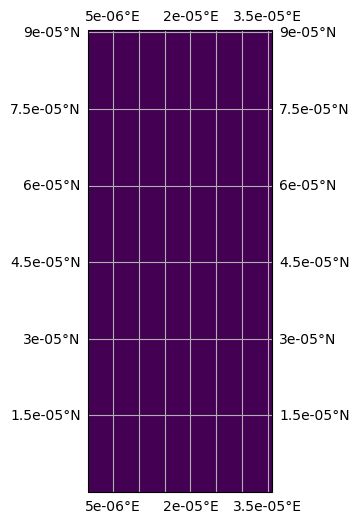

In [36]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.pcolormesh(grid_counts_all)

In [34]:
likelihood = grid_counts/grid_counts_all

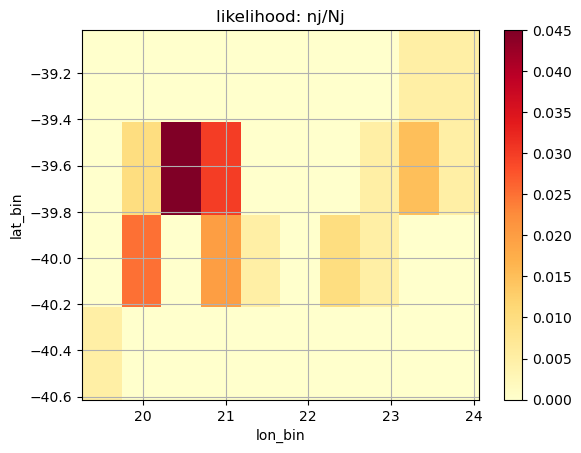

In [38]:
likelihood.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], cmap='YlOrRd')
plt.title('likelihood: nj/Nj')
plt.grid()

### Equal Prior Probability

In [35]:
prior = grid_counts_all/len(fwd.trajectory)

### Variable Prior Probability

Variable prior by LATITUDE:

In [36]:
varprior1 = (grid_counts_all[:,0:3]-4)
varprior2 = (grid_counts_all[:,3:7]+7)
varprior3 = (grid_counts_all[:,7:11]-4)

In [37]:
varprior = xr.concat([varprior1, varprior2,varprior3], dim='lat_bin')/len(fwd.trajectory)

Variable prior by LONGITUDE:

In [38]:
len(grid_counts_all)

10

In [39]:
varprior1 = (grid_counts_all[0:23]+(25/2)) 
varprior2 = (grid_counts_all[23:48]-(23/2))

In [40]:
varprior = xr.concat([varprior1, varprior2], dim='lon_bin')/len(fwd.trajectory)

Check if sum of all prior probabilities is 1!!!

In [41]:
np.sum(prior)

<xarray.DataArray ()>
array(1.)

In [42]:
np.sum(varprior)

<xarray.DataArray ()>
array(1.0625)

### Posterior (and norm. const.)

In [43]:
norm_const = len(hits[0])/len(fwd.trajectory)
posterior = (likelihood*prior)/norm_const

In [44]:
norm_const = len(hits[0])/len(fwd.trajectory)
varposterior = (likelihood*varprior)/norm_const

In [45]:
np.sum(posterior)

<xarray.DataArray ()>
array(1.)

For equal prior:

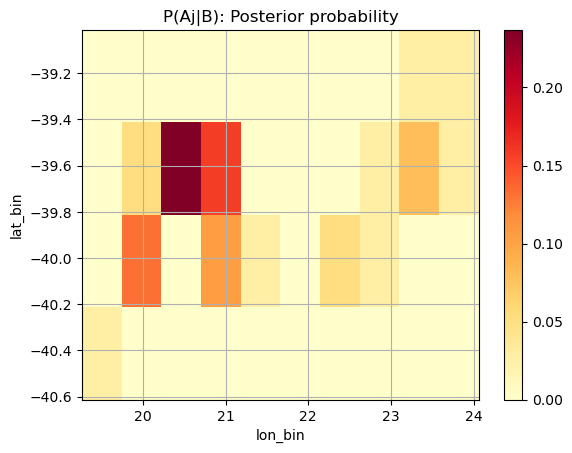

In [46]:
posterior.plot(x=posterior.dims[0], y=posterior.dims[1], cmap='YlOrRd')
plt.title('P(Aj|B): Posterior probability')
plt.grid()


For variable prior: 

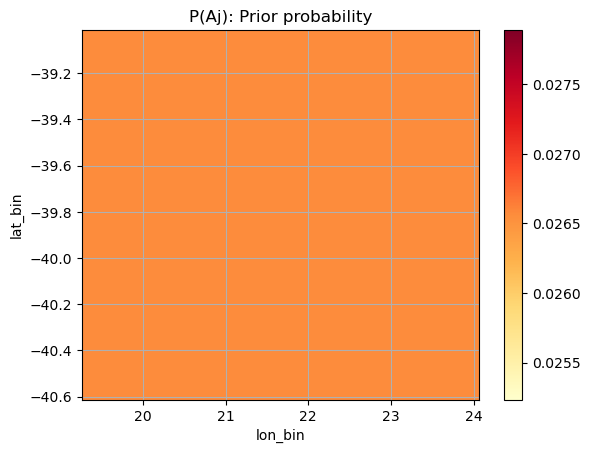

In [72]:
varprior.plot(x=varprior.dims[0], y=varprior.dims[1], cmap='YlOrRd')
plt.title('P(Aj): Prior probability')
plt.grid()

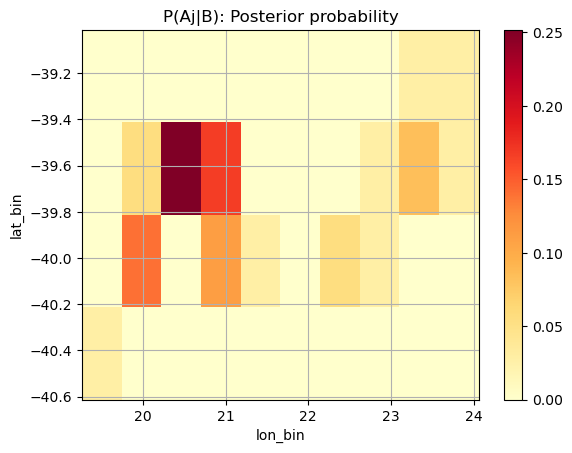

In [73]:
varposterior.plot(x=varposterior.dims[0], y=varposterior.dims[1], cmap='YlOrRd')
plt.title('P(Aj|B): Posterior probability')
plt.grid()

17:17:54 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
17:17:54 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


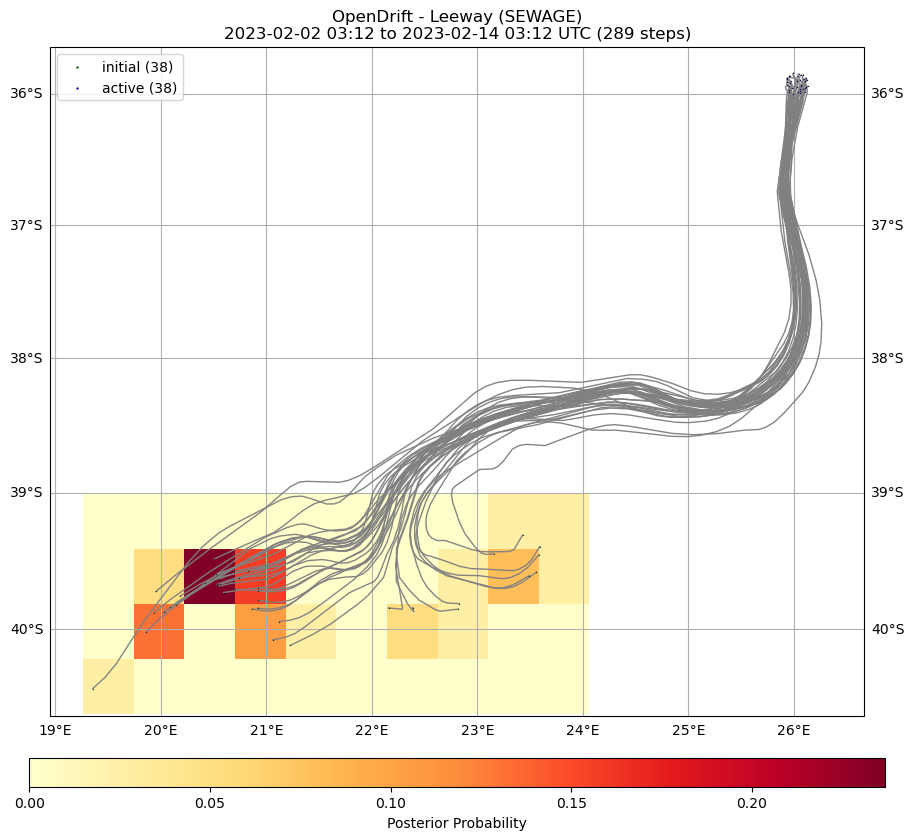

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 2 Axes>)

In [74]:
o_hit.plot(posterior, clabel='Posterior Probability', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

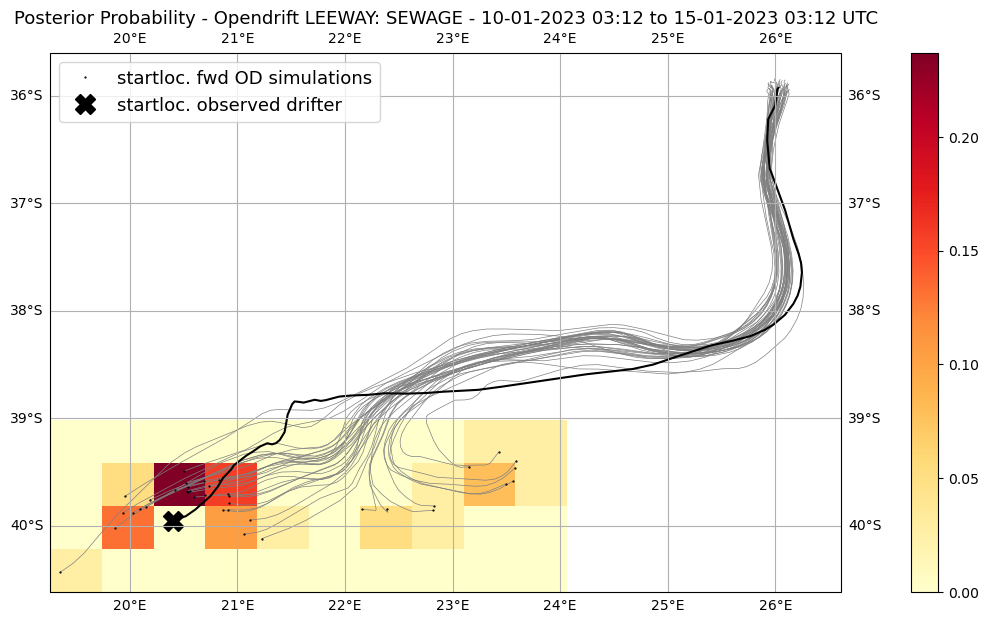

In [54]:
fig = plt.figure(1, figsize=(18,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([18, 22, -36, -39])

ax.gridlines(draw_labels=True)
ax.coastlines(facecolor='black')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)


### Plotting simulations and drifter trajectories ### 

#posterior.plot.pcolormesh(x="lon_bin", y="lat_bin", ax=ax, cmap='YlOrRd', infer_intervals=True)

for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='grey')
    ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=0.6, transform=ccrs.PlateCarree(), label='startloc. fwd OD simulations')

ax.plot(d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-02 03:12:08')).lon.values, d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-02 03:12:08')).lat.values, 'X', color='black', mec='black', markersize=14, transform=ccrs.PlateCarree(), label='startloc. observed drifter')  
d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')

post = posterior.plot.pcolormesh(x="lon_bin", y="lat_bin", ax=ax, cmap='YlOrRd', label='Posterior probability')
#fig.colorbar(post, ax=ax, location='right', label='Posterior')

plt.legend(fontsize=13)
plt.gca().autoscale()
plt.title('Posterior Probability - Opendrift LEEWAY: SEWAGE - 10-01-2023 03:12 to 15-01-2023 03:12 UTC', fontsize=13)
plt.show() 

# BWD

In [57]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd0214feb_nodif38.nc"
back59 = xr.open_dataset(outfile_bwd)

In [58]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(back59.trajectory)):
    lonback.append(back59.isel(trajectory=i).lon.values[-1])
    latback.append(back59.isel(trajectory=i).lat.values[-1])

In [59]:
grid_counts_back = count_points_in_grid(lonback, latback, lon_bins, lat_bins)

In [60]:
o_back = opendrift.open(outfile_bwd)

13:47:51 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
13:47:51 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
13:47:51 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
13:47:51 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
13:47:51 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
13:47:51 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
13:47:51 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_bwd0214feb_nodif38.nc
13:47:51 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
13:47:51 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
13:47:51 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
13:47:51 DEBUG   opendrift.export.io_n

13:47:52 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
13:47:52 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


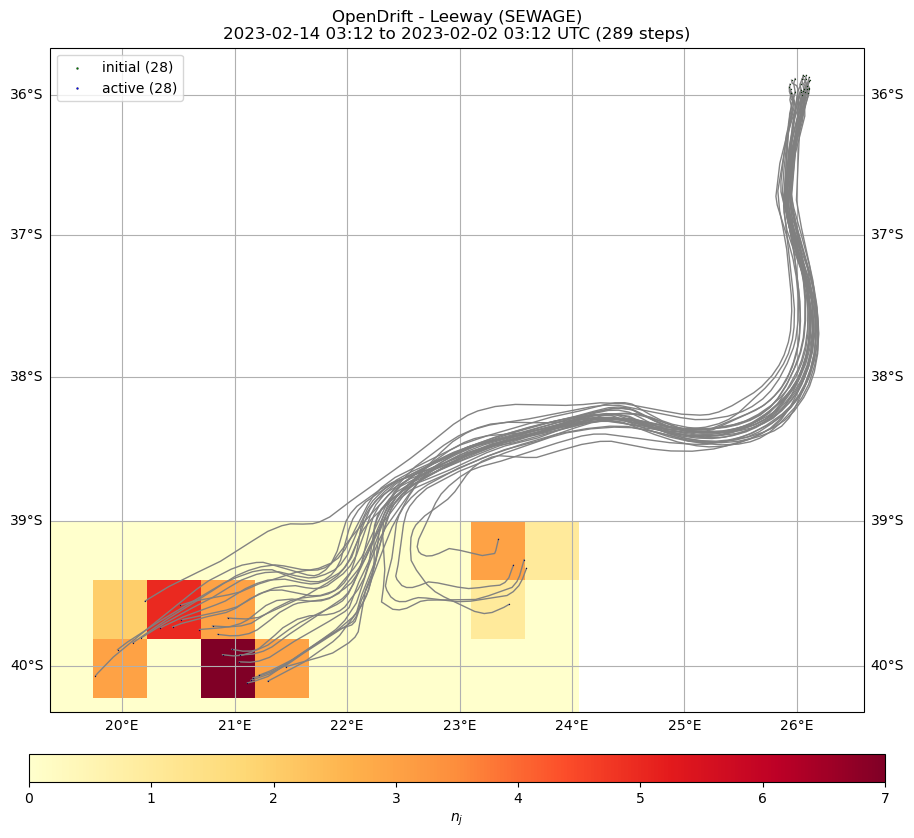

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-14 03:12 to 2023-02-02 03:12 UTC (289 steps)'}>,
 <Figure size 1100x898.576 with 2 Axes>)

In [61]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0, cmap='YlOrRd')

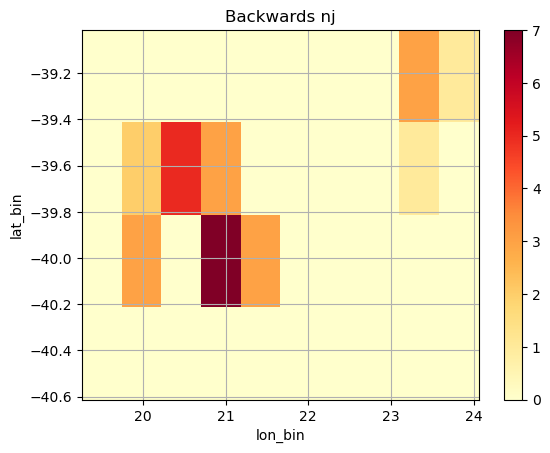

In [62]:
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.title('Backwards nj')
plt.grid()

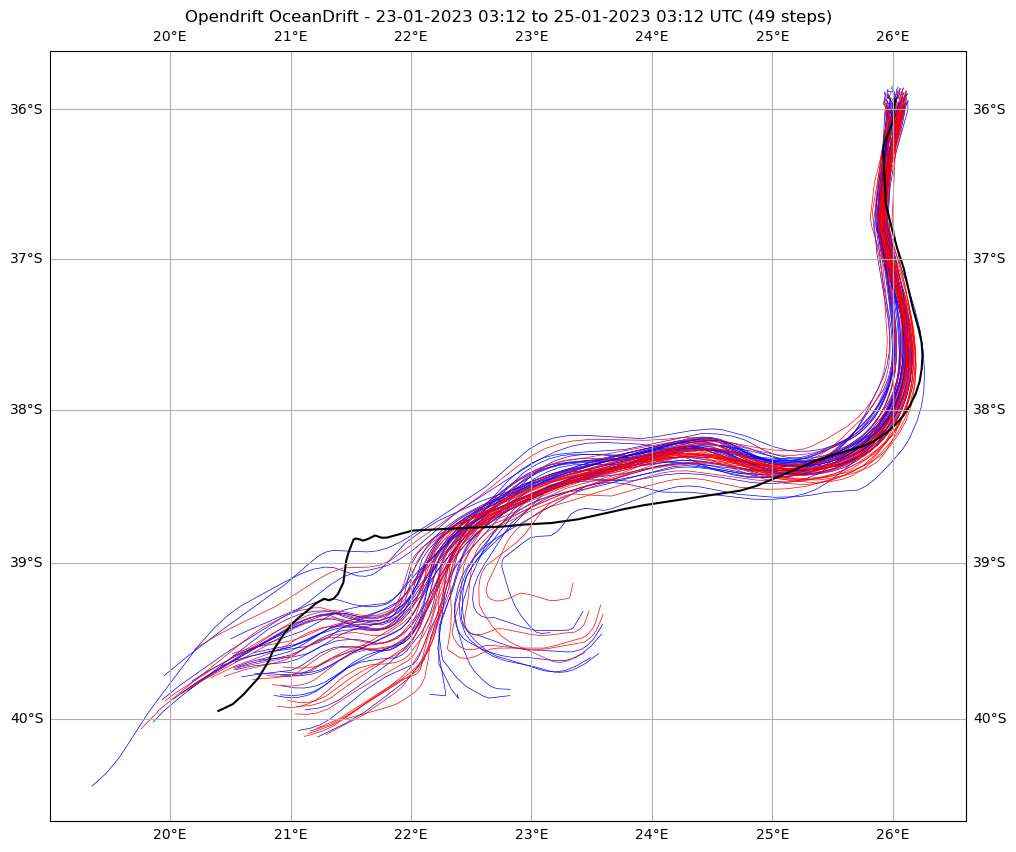

In [63]:
fig = plt.figure(1, figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent([18, 22, -36, -39])

ax.gridlines(draw_labels=True)
ax.coastlines(facecolor='black')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)


### Plotting simulations and drifter trajectories ### 

for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')

back59.traj.plot(linewidth=0.5,color='red')

# ax.plot(back192.isel(time=0).lon.values, back192.isel(time=0).lat.values, 'ro', markersize=0.5, transform=ccrs.Geodetic())
# for i in hits: 
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', markersize=0.5, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-02-02 03:12:08', '2023-02-14 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

13:47:55 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
13:47:55 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


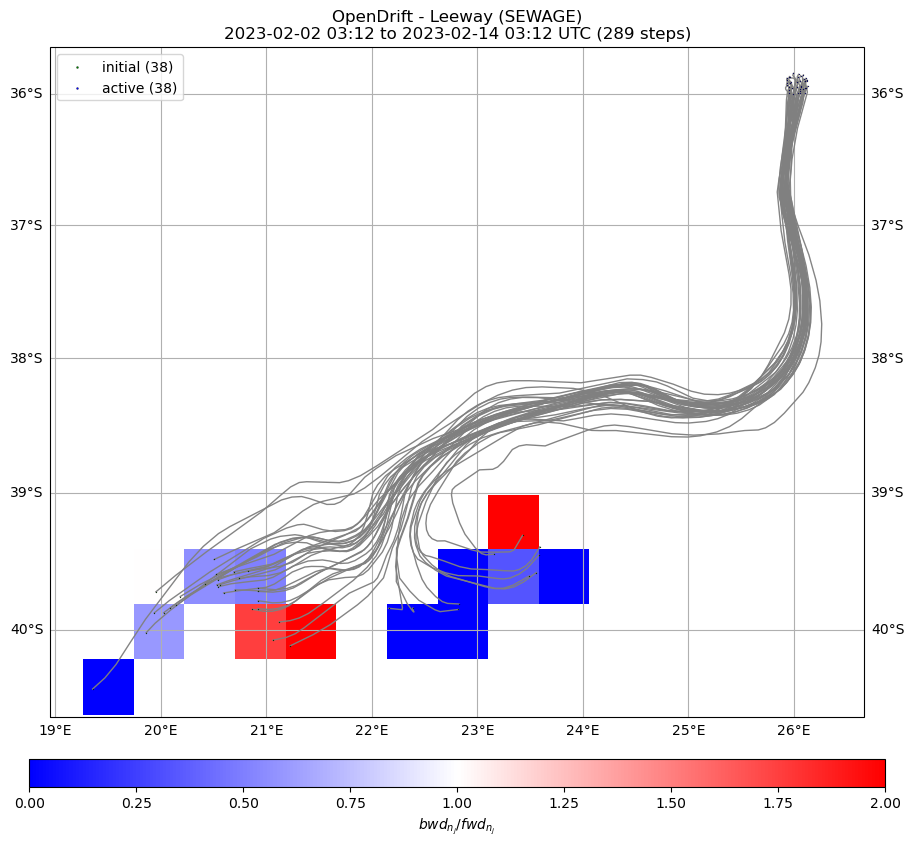

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-02 03:12 to 2023-02-14 03:12 UTC (289 steps)'}>,
 <Figure size 1100x904.424 with 2 Axes>)

In [64]:
o_hit.plot(background=grid_counts_back/grid_counts, clabel='$bwd_{n_j} / fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=2)

13:47:57 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
13:47:57 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


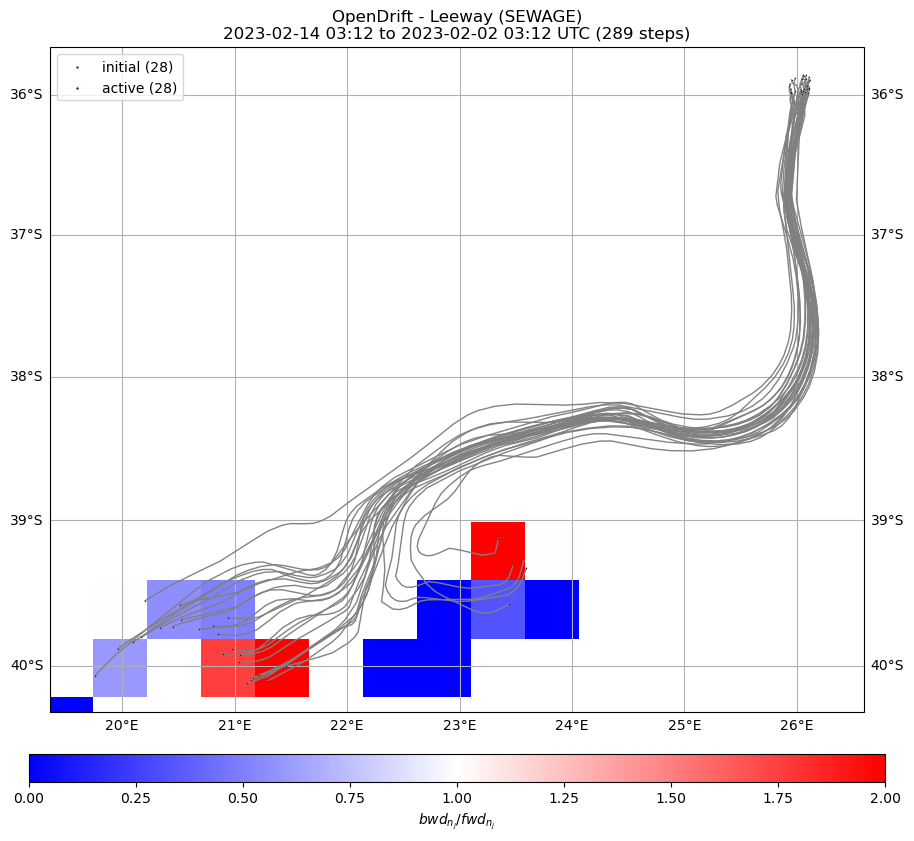

(<GeoAxes: title={'center': 'OpenDrift - Leeway (SEWAGE)\n2023-02-14 03:12 to 2023-02-02 03:12 UTC (289 steps)'}>,
 <Figure size 1100x898.576 with 2 Axes>)

In [65]:
o_back.plot(background=grid_counts_back/grid_counts, clabel='$bwd_{n_j} / fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=2)